# Primary Data Acquisition

## Primary Data Acquisition – Environment Setup

Google Colab was used as the development environment to collect and preprocess Google Places review data. The raw review dataset was generated using the Google Places API and stored locally as a CSV file. This setup allowed structured processing of customer feedback collected from beauty-related businesses.

### Loading Primary Dataset

The primary dataset was loaded into a pandas DataFrame for inspection and preprocessing.

In [34]:

import pandas as pd
import numpy as np
import re

# Load the primary Google reviews dataset
df = pd.read_csv("/content/unstructured_reviews_readable (1).csv")

# Preview and dimensions
df.head(), df.shape

(                      place_id  \
 0  ChIJ6_3yMNUEdkgRgYFYwtACqqo   
 1  ChIJ6_3yMNUEdkgRgYFYwtACqqo   
 2  ChIJ6_3yMNUEdkgRgYFYwtACqqo   
 3  ChIJ6_3yMNUEdkgRgYFYwtACqqo   
 4  ChIJ6_3yMNUEdkgRgYFYwtACqqo   
 
                                          review_text  rating          time  \
 0  Finally went to Liberty London, and what an am...     5.0  1.768254e+09   
 1  Really nice shopping day at Liberty. Their Chr...     5.0  1.763623e+09   
 2  Liberty is the destination of dreams for anyon...     5.0  1.765221e+09   
 3  Beautiful store with an amazing range for all ...     5.0  1.766918e+09   
 4  Such a cool building both inside and out. Real...     5.0  1.762990e+09   
 
   relative_time_description language  
 0               3 weeks ago       en  
 1              2 months ago       en  
 2               a month ago       en  
 3               a month ago       en  
 4              2 months ago       en  ,
 (2030, 6))

The dataset was successfully loaded. It contains review text, ratings, timestamps, and business identifiers required for further preprocessing and sentiment analysis.

## Primary Data Preprocessing & Cleaning

The raw Google review dataset was inspected to validate structure and prepare it for analysis. The dataset includes textual feedback, star ratings, timestamps, and place identifiers.

In [35]:

# Rename columns to align with secondary dataset structure
primary_clean = df.rename(columns={
    "place_id": "business_id",
    "review_text": "text",
    "rating": "stars",
    "time": "date"
}).copy()
# Preview updated structure
primary_clean.head(), primary_clean.shape

(                   business_id  \
 0  ChIJ6_3yMNUEdkgRgYFYwtACqqo   
 1  ChIJ6_3yMNUEdkgRgYFYwtACqqo   
 2  ChIJ6_3yMNUEdkgRgYFYwtACqqo   
 3  ChIJ6_3yMNUEdkgRgYFYwtACqqo   
 4  ChIJ6_3yMNUEdkgRgYFYwtACqqo   
 
                                                 text  stars          date  \
 0  Finally went to Liberty London, and what an am...    5.0  1.768254e+09   
 1  Really nice shopping day at Liberty. Their Chr...    5.0  1.763623e+09   
 2  Liberty is the destination of dreams for anyon...    5.0  1.765221e+09   
 3  Beautiful store with an amazing range for all ...    5.0  1.766918e+09   
 4  Such a cool building both inside and out. Real...    5.0  1.762990e+09   
 
   relative_time_description language  
 0               3 weeks ago       en  
 1              2 months ago       en  
 2               a month ago       en  
 3               a month ago       en  
 4              2 months ago       en  ,
 (2030, 6))

Column names were standardized to ensure compatibility with the secondary Yelp dataset, enabling consistent comparative analysis.


### Converting Timestamp to Datetime

In [36]:
ts = pd.to_numeric(primary_clean["date"], errors="coerce")
unit = "ms" if ts.dropna().astype(float).median() >= 1e12 else "s"

primary_clean["date"] = pd.to_datetime(ts, unit=unit, errors="coerce")

primary_clean["date"].head(), primary_clean["date"].dtype

(0   2026-01-12 21:46:56
 1   2025-11-20 07:19:31
 2   2025-12-08 19:17:38
 3   2025-12-28 10:38:05
 4   2025-11-12 23:19:42
 Name: date, dtype: datetime64[ns],
 dtype('<M8[ns]'))


The timestamp column was converted to datetime format to support chronological analysis.


### Handling Missing Text Values

In [37]:
before_shape = primary_clean.shape

primary_clean = primary_clean.dropna(subset=["text"])
primary_clean = primary_clean[primary_clean["text"].astype(str).str.strip() != ""]

after_shape = primary_clean.shape

before_shape, after_shape

((2030, 6), (2029, 6))


All retained records contain valid textual content, ensuring reliability for text-based analysis.


### Checking for Duplicate Records

In [38]:
dup_rows = primary_clean.duplicated(subset=["business_id", "text", "date"]).sum()
dup_rows

np.int64(0)

No duplicate review records were detected, confirming dataset uniqueness.



### Validating Rating Values

In [39]:

primary_clean["stars"] = pd.to_numeric(primary_clean["stars"], errors="coerce")
primary_clean = primary_clean[primary_clean["stars"].between(1, 5)]
primary_clean["stars"] = primary_clean["stars"].astype(int)

primary_clean["stars"].dtype, primary_clean["stars"].unique()

(dtype('int64'), array([5, 1, 2, 4, 3]))


Star ratings were verified to fall within the expected 1–5 scale. No invalid entries were found.

### Creating Review Length Feature

In [40]:

def map_sentiment(stars):
    if stars <= 2:
        return "Negative"
    elif stars == 3:
        return "Neutral"
    else:
        return "Positive"

primary_clean["sentiment_label"] = primary_clean["stars"].apply(map_sentiment)

primary_clean[["stars", "sentiment_label"]].head()

,stars,sentiment_label
0,5,Positive
1,5,Positive
2,5,Positive
3,5,Positive
4,5,Positive


The review_length feature enables quantitative exploration of textual engagement patterns.

### Creating Sentiment Labels

Sentiment categories were derived from star ratings to support exploratory analysis and comparison with the secondary dataset.


In [41]:
# Define sentiment mapping function
def map_sentiment(stars):
    if stars <= 2:
        return "Negative"
    elif stars == 3:
        return "Neutral"
    else:
        return "Positive"
        # Apply sentiment mapping
primary_clean["sentiment_label"] = (
    primary_clean["stars"]
    .apply(map_sentiment)
)

# Preview sentiment results
primary_clean[["stars", "sentiment_label"]].head()


,stars,sentiment_label
0,5,Positive
1,5,Positive
2,5,Positive
3,5,Positive
4,5,Positive


Sentiment labeling transforms numerical ratings into interpretable categorical variables.

### Light Text Normalization

Review text was lightly normalized by converting to lowercase, removing URLs, and standardizing whitespace. Advanced NLP preprocessing was intentionally avoided to preserve linguistic authenticity.


In [42]:
def clean_text_func(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)   # remove URLs
    text = re.sub(r"\s+", " ", text)      # normalize whitespace
    return text.strip()

primary_clean["clean_text"] = primary_clean["text"].apply(clean_text_func)

primary_clean[["text", "clean_text"]].head()

,text,clean_text
0,"Finally went to Liberty London, and what an am...","finally went to liberty london, and what an am..."
1,Really nice shopping day at Liberty. Their Chr...,really nice shopping day at liberty. their chr...
2,Liberty is the destination of dreams for anyon...,liberty is the destination of dreams for anyon...
3,Beautiful store with an amazing range for all ...,beautiful store with an amazing range for all ...
4,Such a cool building both inside and out. Real...,such a cool building both inside and out. real...



Text normalization improves consistency while maintaining natural review structure.

## Advanced Text Processing Techniques
### NLTK Setup

In [43]:
import nltk
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

"NLTK ready"


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


'NLTK ready'

In [44]:


import re

def advanced_preprocess(text):
    # Lowercase
    text = str(text).lower()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove punctuation & numbers
    text = re.sub(r'[^a-z\s]', ' ', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join back
    return " ".join(tokens).strip()



### Apply Processing

In [45]:
primary_clean['processed_text'] = primary_clean['text'].apply(advanced_preprocess)

primary_clean[['text', 'processed_text']].head()


,text,processed_text
0,"Finally went to Liberty London, and what an am...",finally went liberty london amazing store ente...
1,Really nice shopping day at Liberty. Their Chr...,really nice shopping day liberty christmas dec...
2,Liberty is the destination of dreams for anyon...,liberty destination dream anyone sews stitch e...
3,Beautiful store with an amazing range for all ...,beautiful store amazing range age amazing hist...
4,Such a cool building both inside and out. Real...,cool building inside really came cruella movie...


### Bag of Words

In [46]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(
    max_features=5000
)

X_bow = bow_vectorizer.fit_transform(
    primary_clean['processed_text']
)

X_bow.shape


(2029, 5000)

### TF-IDF

In [47]:

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000
)

X_tfidf = tfidf_vectorizer.fit_transform(
    primary_clean['processed_text']
)

X_tfidf.shape


(2029, 5000)


### Creating Final Structured Dataset

In [48]:
primary_clean = primary_clean.reset_index(drop=True)
primary_clean["review_id"] = primary_clean.index.astype(str)

final_primary = primary_clean[
    ["review_id", "business_id", "stars", "sentiment_label", "clean_text", "processed_text", "date"]
].copy()

final_primary.head(), final_primary.shape

(  review_id                  business_id  stars sentiment_label  \
 0         0  ChIJ6_3yMNUEdkgRgYFYwtACqqo      5        Positive   
 1         1  ChIJ6_3yMNUEdkgRgYFYwtACqqo      5        Positive   
 2         2  ChIJ6_3yMNUEdkgRgYFYwtACqqo      5        Positive   
 3         3  ChIJ6_3yMNUEdkgRgYFYwtACqqo      5        Positive   
 4         4  ChIJ6_3yMNUEdkgRgYFYwtACqqo      5        Positive   
 
                                           clean_text  \
 0  finally went to liberty london, and what an am...   
 1  really nice shopping day at liberty. their chr...   
 2  liberty is the destination of dreams for anyon...   
 3  beautiful store with an amazing range for all ...   
 4  such a cool building both inside and out. real...   
 
                                       processed_text                date  
 0  finally went liberty london amazing store ente... 2026-01-12 21:46:56  
 1  really nice shopping day liberty christmas dec... 2025-11-20 07:19:31  
 2  liberty destin


The cleaned primary dataset now mirrors the secondary dataset structure, ensuring alignment for comparative exploratory analysis.



### Saving Cleaned Primary Dataset

In [49]:
final_primary.to_csv("primary_google_beauty_reviews_cleaned.csv", index=False)
"Saved: primary_google_beauty_reviews_cleaned.csv"

'Saved: primary_google_beauty_reviews_cleaned.csv'

The primary dataset was cleaned, validated, and structured for analysis. Ratings were verified, sentiment labels were derived, review text was lightly normalized, and no duplicate or missing records were retained. The resulting structured dataset is ready for exploratory data analysis and direct comparison with the secondary Yelp dataset.

# Exploratory Data Analysis (EDA)

## Objective

The objective of this section is to explore the cleaned primary Google beauty reviews dataset in order to identify distributions, rating behavior patterns, sentiment proportions, textual engagement characteristics, and potential anomalies using statistical summaries and visualizations.

### Basic Overview of the Primary Dataset

In [24]:
# Basic overview of the primary dataset

final_primary.shape
final_primary.info()
final_primary.isnull().sum()
final_primary.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2029 entries, 0 to 2028
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   review_id        2029 non-null   object        
 1   business_id      2029 non-null   object        
 2   stars            2029 non-null   int64         
 3   sentiment_label  2029 non-null   object        
 4   clean_text       2029 non-null   object        
 5   processed_text   2029 non-null   object        
 6   date             2029 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 111.1+ KB


,stars,date
count,2029.000000,2029
mean,4.280434,2024-07-25 00:43:56.461803776
min,1.000000,2012-06-08 13:26:19
25%,5.000000,2024-05-11 15:18:06
50%,5.000000,2025-08-28 08:38:28
75%,5.000000,2025-12-09 19:06:48
max,5.000000,2026-02-04 14:51:25
std,1.438659,NaN


The primary dataset was inspected to understand its overall structure and verify data completeness. The dataset contains structured review identifiers, business identifiers, star ratings, sentiment labels, cleaned review text, and timestamps. No missing values were detected in the analytical columns.

## Distribution Analysis

# Proportion of Star Ratings (Pie Chart)


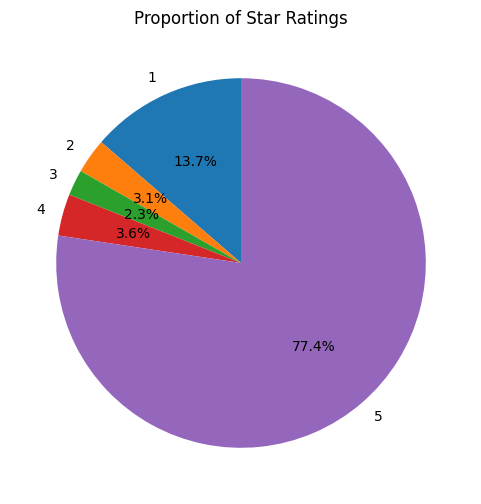

In [25]:

rating_counts = final_primary["stars"].value_counts().sort_index()

plt.figure(figsize=(6,6))

plt.pie(
    rating_counts,
    labels=rating_counts.index,
    autopct="%1.1f%%",
    startangle=90
)

plt.title("Proportion of Star Ratings")

plt.show()

The pie chart illustrates the proportional distribution of star ratings in the primary dataset.

Five-star reviews represent the largest share of the dataset, accounting for the majority of observations. Lower ratings such as 1-, 2-, and 3-star reviews constitute a comparatively smaller portion.

This indicates that the dataset is skewed toward positive feedback, reflecting generally high customer satisfaction levels or potential positivity bias in voluntary online review behavior.

In [26]:
# Examine sentiment distribution

sentiment_distribution = final_primary["sentiment_label"].value_counts()

sentiment_distribution

,count
sentiment_label,
Positive,1644
Negative,339
Neutral,46




# Primary Dataset Sentiment Distribution




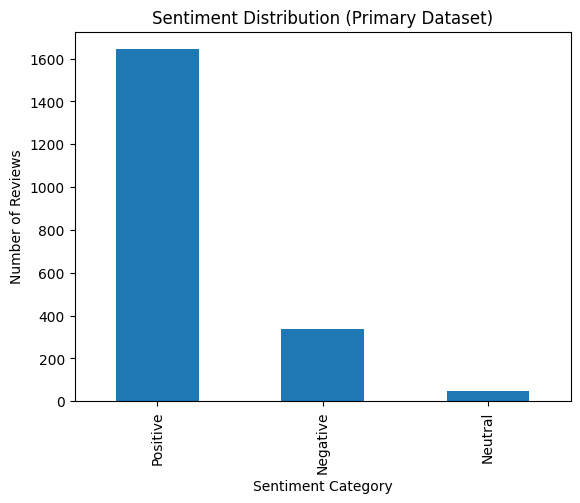

In [27]:
#Visualization of Sentiment Proportions

# Plot sentiment distribution
plt.figure()
final_primary["sentiment_label"].value_counts().plot(kind="bar")

plt.title("Sentiment Distribution (Primary Dataset)")
plt.xlabel("Sentiment Category")
plt.ylabel("Number of Reviews")
plt.show()

Sentiment labels derived from star ratings allow categorical analysis. This distribution highlights the proportion of Positive, Neutral, and Negative reviews.

### 2- Distribution Review Length


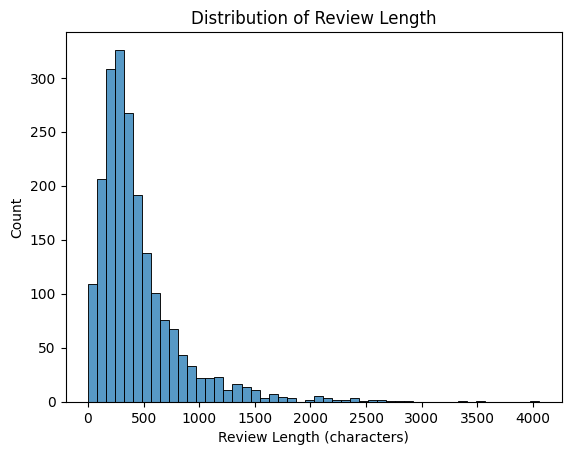

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create review length feature
final_primary["review_length"] = (
    final_primary["clean_text"]
    .astype(str)
    .str.len()
)

# Plot histogram using seaborn
plt.figure()
sns.histplot(final_primary["review_length"], bins=50)

plt.title("Distribution of Review Length")
plt.xlabel("Review Length (characters)")
plt.ylabel("Count")
plt.show()

The distribution of review length is right-skewed, indicating that most reviews are relatively short, while only a small proportion are substantially longer.

The majority of reviews fall below 1,000 characters, with a long tail extending beyond 3,000 characters. This suggests that while most users provide brief and concise feedback, a smaller segment contributes detailed and extensive descriptions of their experiences.

### Cumulative Distribution of Review Length (ECDF)

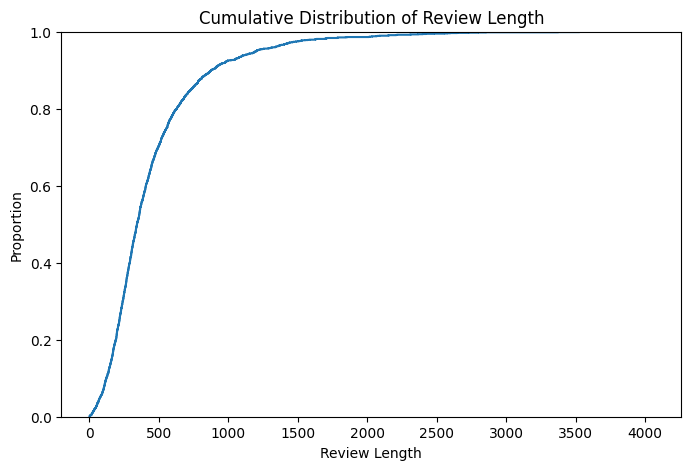

In [29]:
plt.figure(figsize=(8,5))

sns.ecdfplot(data=final_primary, x="review_length")

plt.title("Cumulative Distribution of Review Length")
plt.xlabel("Review Length")
plt.ylabel("Proportion")

plt.show()

The ECDF plot demonstrates the cumulative distribution of review lengths.

The steep rise at lower character counts indicates that a large proportion of reviews are short. As the curve gradually flattens, it reveals that only a small fraction of reviews reach very high lengths.

This further confirms the right-skewed nature of review length distribution, where short reviews dominate and long reviews are relatively rare.

## Relationship Analysis
### 1- Review Length vs Star Rating

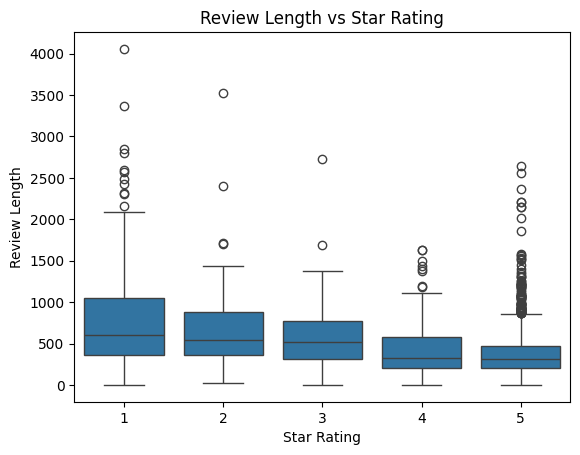

In [30]:
plt.figure()

sns.boxplot(
    x="stars",
    y="review_length",
    data=final_primary
)

plt.title("Review Length vs Star Rating")
plt.xlabel("Star Rating")
plt.ylabel("Review Length")

plt.show()



The boxplot illustrates the relationship between review length and star rating.

Lower star ratings (particularly 1 and 2 stars) tend to exhibit slightly higher median review lengths compared to higher ratings. In contrast, 5-star reviews generally appear shorter on average.

However, the differences are not substantial, indicating that review length does not vary dramatically across rating categories. Numerous outliers are visible in all groups, suggesting that highly detailed reviews occur across both positive and negative ratings.

### Correlation Analysis

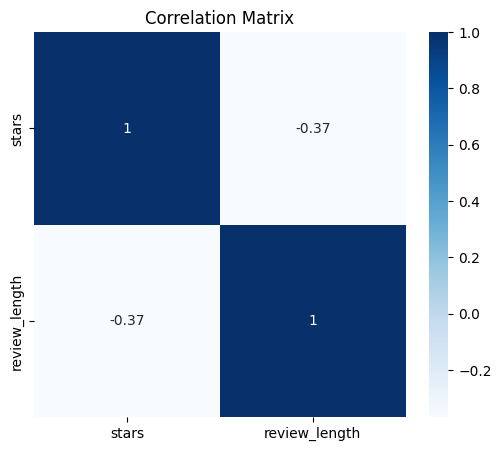

In [31]:
plt.figure(figsize=(6,5))

sns.heatmap(
    final_primary[["stars","review_length"]].corr(),
    annot=True,
    cmap="Blues"
)

plt.title("Correlation Matrix")
plt.show()

The correlation matrix provides insight into relationships between numerical variables.

A slight negative correlation between star rating and review length may be observed, suggesting that lower-rated reviews tend to be somewhat longer.

However, the magnitude of the correlation is generally weak, indicating that rating level alone does not strongly determine how much detail a customer provides.

## Trend Analysis

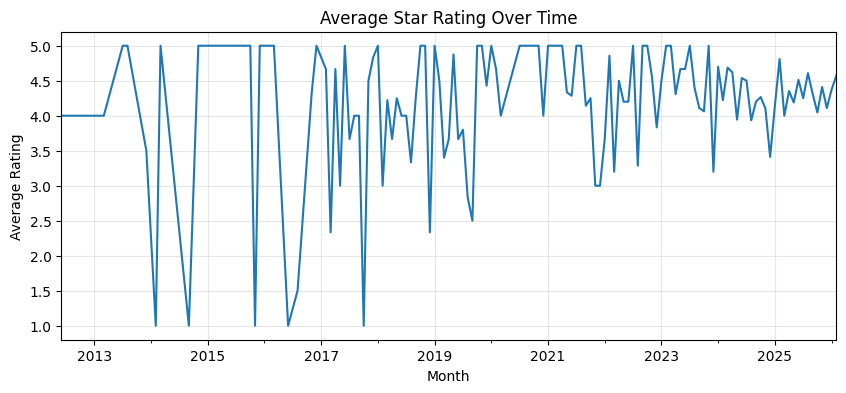

In [32]:
final_primary["date"] = pd.to_datetime(final_primary["date"], errors="coerce")

monthly_avg = final_primary.dropna(subset=["date"]).groupby(
    final_primary["date"].dt.to_period("M")
)["stars"].mean()

plt.figure(figsize=(10,4))
monthly_avg.plot()

plt.title("Average Star Rating Over Time")
plt.xlabel("Month")
plt.ylabel("Average Rating")

plt.grid(True, alpha=0.3)
plt.show()


The average star rating over time appears relatively stable throughout the observed period.

While short-term fluctuations are visible, the overall trend remains consistent, indicating stable customer sentiment over time. There is no strong evidence of a sustained upward or downward trend in ratings.

# Text-Based Exploratory Analysis

# Top 20 Words

In [50]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import pandas as pd

cv = CountVectorizer(min_df=2)
X = cv.fit_transform(final_primary["processed_text"].astype(str))

word_counts = X.sum(axis=0).A1
vocab = cv.get_feature_names_out()

top_n = 20
top_idx = word_counts.argsort()[::-1][:top_n]

top_words = pd.DataFrame({
    "word": vocab[top_idx],
    "count": word_counts[top_idx].astype(int)
})

top_words

,word,count
0,experience,718
1,time,700
2,treatment,616
3,recommend,595
4,feel,583
5,staff,582
6,service,578
7,hair,574
8,would,546
9,really,522


This analysis identifies the most frequently occurring words in the processed review texts. By examining word frequency after preprocessing (tokenization and lemmatization), we can determine the main themes discussed by customers. Frequent terms provide insight into common topics, such as service quality, staff behavior, pricing, or overall experience.

# Top 10 Bigram

In [51]:
cv2 = CountVectorizer(ngram_range=(2,2), min_df=2)
X2 = cv2.fit_transform(final_primary["processed_text"].astype(str))

bigram_counts = X2.sum(axis=0).A1
bigrams = cv2.get_feature_names_out()

top_n = 10
top_idx = bigram_counts.argsort()[::-1][:top_n]

top_bigrams = pd.DataFrame({
    "bigram": bigrams[top_idx],
    "count": bigram_counts[top_idx].astype(int)
})

top_bigrams

,bigram,count
0,highly recommend,253
1,made feel,167
2,customer service,108
3,first time,106
4,feel comfortable,89
5,make feel,83
6,took time,78
7,would recommend,72
8,would highly,71
9,highly recommended,68


This analysis examines the most common two-word combinations (bigrams) in the processed review texts. Unlike single-word frequency, bigrams capture contextual relationships between words, allowing for a more precise understanding of recurring customer concerns or positive aspects, such as "customer service" or "waiting time."

# TF-IDF Analysis

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(final_primary["processed_text"].astype(str))

tfidf_scores = X_tfidf.mean(axis=0).A1
terms = tfidf.get_feature_names_out()

top_n = 20
top_idx = tfidf_scores.argsort()[::-1][:top_n]

top_tfidf = pd.DataFrame({
    "term": terms[top_idx],
    "avg_tfidf": tfidf_scores[top_idx]
}).sort_values("avg_tfidf", ascending=False)

top_tfidf

,term,avg_tfidf
0,massage,0.025853
1,great,0.025645
2,service,0.025540
3,hair,0.025483
4,experience,0.025350
5,recommend,0.024798
6,time,0.024693
7,amazing,0.024100
8,treatment,0.024043
9,staff,0.023689


TF-IDF analysis highlights the most informative and distinctive terms within the review corpus. Unlike simple frequency counts, TF-IDF assigns higher importance to terms that are unique or particularly representative within the dataset. This helps uncover meaningful patterns beyond commonly repeated words.

# Summary of EDA Findings (Primary Dataset)

In this exploratory data analysis, several key patterns were identified:
 • The majority of reviews are 5-star ratings, indicating generally positive customer experiences.
 • Review lengths follow a right-skewed distribution, with most reviews being relatively short and a small number of very long reviews.
 • A slight negative relationship exists between star rating and review length, suggesting that lower-rated reviews tend to be somewhat longer.
 • Temporal analysis indicates relatively stable average ratings over time, with no strong long-term directional trend.

Overall, the primary dataset reflects stable and predominantly positive customer sentiment. Review behavior appears consistent with typical online review platforms, where positive ratings dominate and detailed feedback is provided by a smaller subset of users.
